# Neural Networks for TKN Prediction in Influent Wastewater

Model Iteration No. 2 - This code uses top 3 SHAP values as project feature inputs (P-TOT, CBOD5, VTS).

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential 

In [2]:
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

In [3]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

In [5]:
influent = pd.read_excel(r"C:\Users\18455\EAEE4000_ML_Jupyter\EAEE4000_WW_Prediction\Appendix_A_Preprocessing_and_DataReview\raw_influent.xlsx")
influent

,Unnamed: 0,Date,BOD5,CBOD5,SS,VSS,TS,VTS,TKN,Nitrates,P-TOT,P-SOL
0,2672,2008-01-01,67,55,82,64,1994,188,18.53,0.72,2.65,1.155
1,2673,2008-01-02,77,57,70,61,1274,196,19.87,0.85,4.22,2.849
2,2674,2008-01-03,94,70,84,69,1096,220,21.49,0.81,5.53,3.809
3,2675,2008-01-04,93,64,72,54,1003,242,19.32,0.65,6.19,4.107
4,2676,2008-01-05,107,75,118,90,1317,280,17.13,0.31,4.16,2.183
...,...,...,...,...,...,...,...,...,...,...,...,...
4378,7706,2019-12-27,0,0,79,61,554,174,14.00,0.66,3.05,1.310
4379,7707,2019-12-28,62,51,48,37,570,130,18.00,0.76,4.47,2.170
4380,7708,2019-12-29,189,115,340,224,962,340,17.00,0.49,4.55,1.240
4381,7709,2019-12-30,74,47,99,68,656,164,14.00,0.88,2.70,1.070


# Prepare the Training Data

See top 3 project input features used here.

In [128]:
# Prepare the training set
X = influent[['P-TOT','CBOD5','VTS']]
Y = influent[['TKN']] 
X_train_df, X_test_df, Y_train_df, Y_test_df = train_test_split(X, Y,
        test_size = 0.2, random_state=4, shuffle=True)

In [129]:
# Normalize the data
mean_x, std_x = X_train_df.mean(), X_train_df.std()
mean_y, std_y = Y_train_df.mean(), Y_train_df.std()

X_train_df = (X_train_df - mean_x)/std_x
X_test_df  = (X_test_df - mean_x)/std_x

Y_train_df = (Y_train_df - mean_y)/std_y
Y_test_df  = (Y_test_df - mean_y)/std_y

X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

X_test = X_test_df.to_numpy()
Y_test = Y_test_df.to_numpy()

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape, )

(3506, 3) (3506, 1)
(877, 3) (877, 1)


# Set Hyperparameters and Model Architecture

In [136]:
# set hyperparameters
n_neuron       = 8 
activation     = 'relu' 
num_epochs     = 50
learning_rate  = 0.007
minibatch_size = 80 
model_num      = 1

In [137]:
model = Sequential()

model.add(Dense(n_neuron,  activation=activation,input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
model.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
model.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
model.add(Dense(n_neuron,  activation=activation)) # the 4th hidden layer
#model.add(Dense(n_neuron,  activation=activation)) # the 5th hidden layer, Not used - determined additional layers did not improve accuracy.
#model.add(Dense(n_neuron,  activation=activation)) # the 6th hidden layer
#model.add(Dense(n_neuron,  activation=activation)) # the 7th hidden layer
#model.add(Dense(n_neuron,  activation=activation)) # the 8th hidden layer
#model.add(Dense(n_neuron,  activation=activation)) # the 9th hidden layer
#model.add(Dense(n_neuron,  activation=activation)) # the 10th hidden layer
model.add(Dense(Y_train.shape[1],  activation='linear')) # the output layer


model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)) # MSE much better than MAE

In [138]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_107 (Dense)           (None, 8)                 32        
                                                                 
 dense_108 (Dense)           (None, 8)                 72        
                                                                 
 dense_109 (Dense)           (None, 8)                 72        
                                                                 
 dense_110 (Dense)           (None, 8)                 72        
                                                                 
 dense_111 (Dense)           (None, 1)                 9         
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


# Evaluate the Model

In [139]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train, Y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1, 
                    callbacks       = [early_stop])

Epoch 1/50
36/36 [==============================] - 1s 12ms/step - loss: 0.5566 - val_loss: 0.7555
Epoch 2/50
36/36 [==============================] - 0s 4ms/step - loss: 0.3696 - val_loss: 0.7278
Epoch 3/50
36/36 [==============================] - 0s 4ms/step - loss: 0.3079 - val_loss: 0.5987
Epoch 4/50
36/36 [==============================] - 0s 4ms/step - loss: 0.2706 - val_loss: 0.6071
Epoch 5/50
36/36 [==============================] - 0s 5ms/step - loss: 0.2626 - val_loss: 0.5744
Epoch 6/50
36/36 [==============================] - 0s 5ms/step - loss: 0.2479 - val_loss: 0.5779
Epoch 7/50
36/36 [==============================] - 0s 4ms/step - loss: 0.2431 - val_loss: 0.5624
Epoch 8/50
36/36 [==============================] - 0s 4ms/step - loss: 0.2541 - val_loss: 0.5410
Epoch 9/50
36/36 [==============================] - 0s 4ms/step - loss: 0.2175 - val_loss: 0.5435
Epoch 10/50
36/36 [==============================] - 0s 5ms/step - loss: 0.2080 - val_loss: 0.5245
Epoch 11/50
36/36 

In [140]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.plot(history.epoch, np.array(history.history['loss']),
            label='Train loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
            label='Val loss')
    plt.legend()

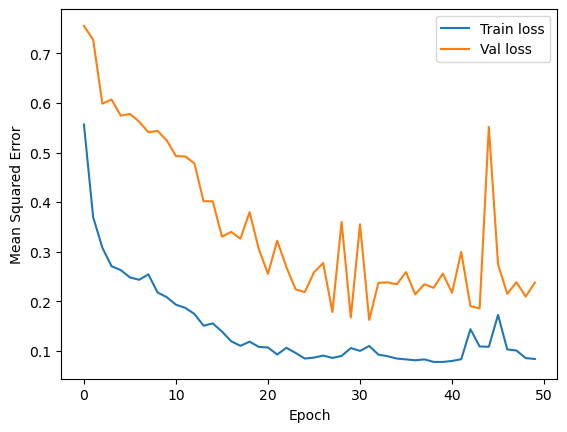

In [141]:
plot_history(history)

# Make Predictions

In [142]:
y_test_predict = model.predict(X_test)
y_test_predict

28/28 [==============================] - 0s 4ms/step


array([[-3.75233471e-01],
       [ 1.73421606e-01],
       [ 4.82434183e-02],
       [-6.26980424e-01],
       [-6.15872502e-01],
       [-9.21892524e-01],
       [-5.46991587e-01],
       [-9.73098218e-01],
       [ 2.95113087e-01],
       [-9.78395492e-02],
       [ 8.67627561e-01],
       [ 2.96529710e-01],
       [-2.12104470e-02],
       [-2.70936430e-01],
       [-2.09502801e-01],
       [-9.66859013e-02],
       [ 2.26834521e-01],
       [-9.80307907e-02],
       [ 1.60149917e-01],
       [ 7.90181756e-03],
       [ 4.36584294e-01],
       [-6.13191426e-01],
       [ 1.61281511e-01],
       [ 1.24088049e+00],
       [-5.53109467e-01],
       [ 1.80828705e-01],
       [ 1.73255980e+00],
       [ 1.28734484e-01],
       [-4.56032515e-01],
       [-1.51222110e-01],
       [ 1.73553348e+00],
       [-5.31289995e-01],
       [ 1.75690010e-01],
       [-5.86433113e-02],
       [-3.49094272e-01],
       [-3.97121370e-01],
       [ 3.56803298e-01],
       [-7.87866175e-01],
       [ 6.8

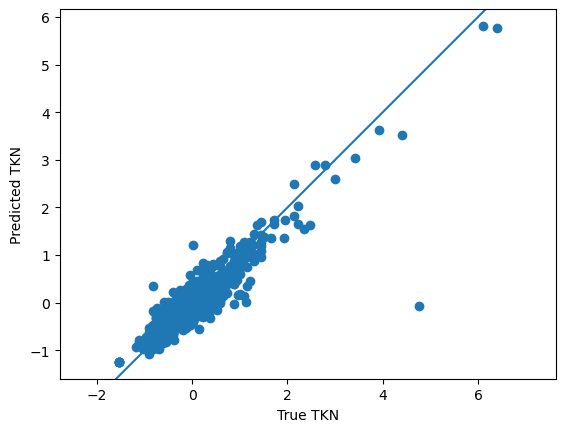

In [143]:
plt.scatter(Y_test, y_test_predict) # this is where y_test comes into play
plt.xlabel('True TKN')
plt.ylabel('Predicted TKN')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

In [144]:
# Calculate predictions & associated Mean Squared Error
mse(Y_test, y_test_predict)

0.09435076185306226

In [145]:
# print out the prediction scores
print('MSE: {}'.format(mse(Y_test, y_test_predict)))
print('RMSE: {}'.format(np.sqrt(mse(Y_test, y_test_predict))))
print('MAE: {}'.format(mae(Y_test, y_test_predict)))
print('R-SQ: {}'.format(r2_score(Y_test, y_test_predict)))

MSE: 0.09435076185306226
RMSE: 0.3071656912043763
MAE: 0.20598496775279543
R-SQ: 0.8208668956980951


In [146]:
model.get_weights()

[array([[ 0.641944  , -0.68298936, -0.5166271 ,  0.8598518 ,  0.03332028,
          0.27133146, -0.2013943 , -0.7566868 ],
        [-0.30954903,  0.38045615, -0.9294079 , -0.6191284 , -0.78747326,
         -1.4310548 ,  0.29821935, -0.063914  ],
        [-0.52149504,  0.1959989 ,  0.09389587,  0.06862367, -1.162017  ,
         -0.23204856,  0.7667904 ,  0.9310058 ]], dtype=float32),
 array([-1.2580763 ,  0.3432119 , -0.5357269 , -0.6839134 , -0.18330653,
         0.38712108,  0.36232015, -0.10673323], dtype=float32),
 array([[-0.17505635,  0.2897061 ,  0.08189531,  0.25210592, -1.2594752 ,
          0.42353067, -0.53649384,  0.03291279],
        [-0.02957099, -0.33254412,  0.20166552, -0.7871972 , -0.57085806,
          0.5297733 ,  0.27959028,  0.05630708],
        [ 0.10286032,  0.23196882, -0.16341518,  0.7659919 ,  0.44303045,
          0.22906108, -0.40810797,  0.6920521 ],
        [ 0.05708778,  0.7880999 , -0.54743993,  0.30329803,  0.24589974,
          0.5305142 , -0.37048638,